In [27]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [28]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:22: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  


In [29]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [30]:
target_days = 50

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [31]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [32]:
# load all models

"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 28s 894us/step - accuracy: 0.5608 - loss: 0.2425 - val_accuracy: 0.5702 - val_loss: 0.2390
Epoch 2/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 728us/step - accuracy: 0.5862 - loss: 0.2369 - val_accuracy: 0.5882 - val_loss: 0.2356
Epoch 3/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 718us/step - accuracy: 0.5978 - loss: 0.2333 - val_accuracy: 0.5996 - val_loss: 0.2330
Epoch 4/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 713us/step - accuracy: 0.6098 - loss: 0.2298 - val_accuracy: 0.6146 - val_loss: 0.2283
Epoch 5/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 710us/step - accuracy: 0.6209 - loss: 0.2260 - val_accuracy: 0.6210 - val_loss: 0.2244
Epoch 6/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 707us/step - accuracy: 0.6292 - loss: 0.2229 - val_accuracy: 0.6269 - val_loss: 0.2234
Epoch 7/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 708us/step - accuracy: 0.6344 - loss: 0.2204 - val_accuracy: 0.6324 - val_loss: 0.2205
Epoch 8/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 4s 707us/step - accuracy: 0.6444 

In [33]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
Ridge Classifier:
Accuracy: 0.5311952843800223
Confusion Matrix:
[[54680 43399]
 [47904 48774]]
Precision: 52.91571284432535
Recall: 50.449947247564076
F1 Score: 51.65341989187243
MSE: 46.88047156199777
RMSE: 68.46931543545458


XGBoost Classifier:
Accuracy: 0.5282839641193898
Confusion Matrix:
[[54641 43438]
 [48432 48246]]
Precision: 52.62204964879368
Recall: 49.90380438155527
F1 Score: 51.22689289771822
MSE: 47.17160358806102
RMSE: 68.68158675224461


LightGBM Classifier:
Accuracy: 0.525593431815031
Confusion Matrix:
[[53843 44236]
 [48158 48520]]
Precision: 52.30928457458278
Recall: 50.18721942944621
F1 Score: 51.226284616277965
MSE: 47.4406568184969
RMSE: 68.87717823669674


Neural Network:
Accuracy: 0.5133730751654626
Confusion Matrix:
[[52606 45473]
 [49301 47377]]
Precision: 51.02530963920302
Recall: 49.00

In [34]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [35]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [36]:
"""def update_df_with_asset_performance(df, portfolios, value, hold_days):
     #Update df by marking assets in portfolios with a specified value starting two days after for a duration. 
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value


# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 1, target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], -1, target_days)"""




"def update_df_with_asset_performance(df, portfolios, value, hold_days):\n     #Update df by marking assets in portfolios with a specified value starting two days after for a duration. \n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) \n\n    # Accumulate best and worst assets for each date\n    for date in best_assets['todate'].unique():\n        po

In [37]:
import pandas as pd

def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):
    """ Update df by marking assets in portfolios with normalized values 
    starting two days after for a duration, such that the absolute sum of values is 1."""
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_13880\2872299294.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09090909090909091' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = value
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_13880\2872299294.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.08333333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = value
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_13880\2872299294.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.07692307692307693' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[s

6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step


C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_13880\2872299294.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09090909090909091' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = value
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_13880\2872299294.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.08333333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = value


In [38]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']
NN_weights = model_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


In [39]:
%reload_ext autoreload
%autoreload 2


In [40]:


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)



In [41]:
xgb_trade_volume.sum()

4178

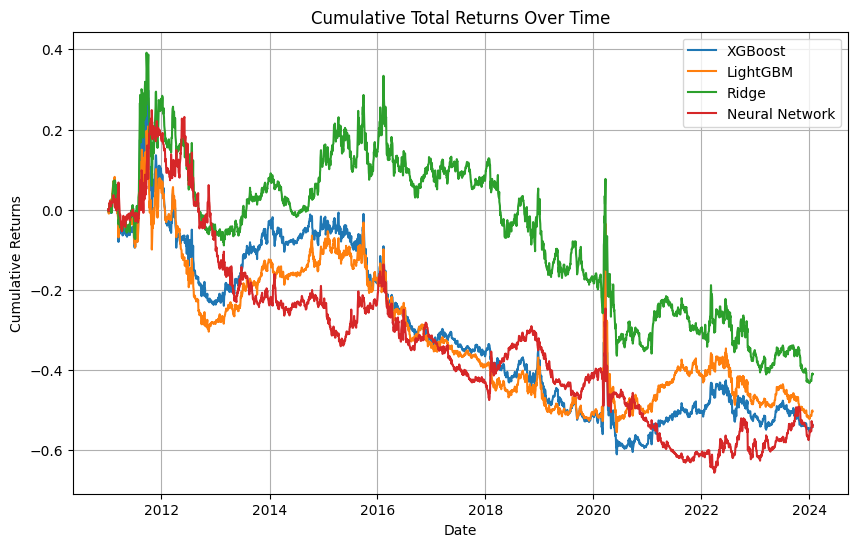

In [77]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [43]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
4178


LightGBM trade volume:
3070


Ridge trade volume:
2726


Neural Network trade volume:
2877




In [44]:
# alla olika ratios föpr olika portföljer som sharpe osv
# fixa NN
xgb_targets = add_target(xgb_returns, [target_days])
lgb_targets = add_target(lgb_returns, [target_days])
ridge_targets = add_target(ridge_returns, [target_days])
NN_targets = add_target(NN_returns, [target_days])

In [45]:
xgb_transformed = transform_and_pivot_df(xgb_targets, date_col)
lgb_transformed = transform_and_pivot_df(lgb_targets, date_col)
ridge_transformed = transform_and_pivot_df(ridge_targets, date_col)
NN_transformed = transform_and_pivot_df(NN_targets, date_col)


In [80]:
%reload_ext autoreload
%autoreload 2


In [81]:
financial_metrics(ridge_total_returns)

{'Average Yearly Return': -0.022073659446972725,
 'Average Yearly Standard Deviation': 0.1871320286998364,
 'Sharpe Ratio': -0.11795767726314413,
 'Max Drawdown': -2.105616089323152,
 'Volatility': 0.1871320286998364,
 'Calmar Ratio': -0.010483230803041726,
 'Skewness': -0.15987542299655427,
 'Kurtosis': 10.686510670034602}